In [1]:
import glob
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table, Table
from biom.util import biom_open
from tqdm.notebook import tqdm
from gemelli.ctf import ctf
from gemelli.joint_ctf import joint_ctf
from skbio.stats.distance import permanova
from scipy.spatial import distance
from skbio import DistanceMatrix
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load filtered tables
body_site = 'Baby-Feces'
mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
bt = load_table('../data/%s/table-filtered.biom' % body_site)

In [3]:
#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep = mf[subject_id_column].value_counts()[mf[subject_id_column].value_counts() > 1].index
mf = mf[mf[subject_id_column].isin(ids_to_keep)]
#remove CSseed babies
mf = mf[mf.birth_mode_ms != 'CSseed']

In [11]:
# inits
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
experiment = 'dispersion'
seq_depth = 10000
# import simulations from file
simulations_depth = {(int(tbl_.split('/')[-1].split('-')[1]),
                      int(tbl_.split('/')[-1].split('-')[2]),
                      int(tbl_.split('/')[-1].split('-')[3].split('.')[0])):load_table(tbl_)
                      for tbl_ in glob.glob('../results/{}-tables/table-{}-*'.format(experiment, seq_depth))}
simulations_depth.keys()

dict_keys([(10000, 2000, 0), (10000, 1000, 2), (10000, 2000, 1), (10000, 500, 0), (10000, 500, 1), (10000, 500, 2), (10000, 1000, 0), (10000, 2000, 2), (10000, 1000, 1)])

In [16]:
# simulation_results_ctf = {}
# for k_sim, bt_tmp in tqdm(simulations_depth.items()):
#     print(k_sim)
#     # run CTF (can re-filter to what you might do normally)
#     simulation_results_ctf[k_sim] = ctf(bt_tmp.copy(), mf, 
#                                         subject_id_column,
#                                         state_column,
#                                         min_sample_count=0)

In [12]:
simulation_results = {}
for k_sim, bt_tmp in tqdm(simulations_depth.items()):
    print(k_sim)
    simulation_results[k_sim] = joint_ctf(tables=[bt_tmp.copy()],
                                          sample_metadatas=[mf],
                                          modality_ids=['16S'],
                                          individual_id_column='subjectid_unique',
                                          state_column='date_sampling_category_days_continuous')
    print()

  0%|          | 0/9 [00:00<?, ?it/s]

(10000, 2000, 0)
Calculate components for component_1
Reached convergence in 20 iterations
Calculate components for component_2
Reached convergence in 9 iterations
Calculate components for component_3
Reached convergence in 21 iterations

(10000, 1000, 2)
Calculate components for component_1
Reached convergence in 9 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 21 iterations

(10000, 2000, 1)
Calculate components for component_1
Reached convergence in 21 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 8 iterations

(10000, 500, 0)
Calculate components for component_1
Reached convergence in 17 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 8 iterations

(10000, 500, 1)
Calculate components for comp

In [21]:
##sim_results = subject_loads, feature_loads, state_loads, subject_lambdas, var_explained, feature_covs

cat_of_interest = 'birth_mode_ms'
permanova_results = {}
for k_sim, (ind_loads, _, _, _, _, _) in tqdm(simulation_results.items()):
    
    ind_loads = ind_loads['16S']
    mf_tmp = mf.copy()
    mf_tmp.index = mf_tmp.subjectid_unique
    mf_tmp = mf_tmp.loc[ind_loads.index, :]
    
    for t_, t_mf in mf_tmp.groupby(state_column):

        # calculate distance for subjects
        dists = distance.cdist(ind_loads.values, ind_loads.values)
        dists = DistanceMatrix(dists, ids=ind_loads.index)
        dists.ids = list(map(str, dists.ids))
        dist_tmp_t = dists.copy().filter(t_mf.index)
        # MAKE SURE IT IS ORDERED CORRECTLY!
        t_mf = t_mf.reindex(dist_tmp_t.ids)
        permanova_results[(k_sim[0], k_sim[1], k_sim[2], t_)] = permanova(dist_tmp_t, 
                                                                t_mf[cat_of_interest])

permanova_results_df = pd.DataFrame(permanova_results).T.reset_index()
permanova_results_df = permanova_results_df.rename({'level_0':'depth',
                                                    'level_1':'dispersion',
                                                    'level_2':'simulation_fold',
                                                    'level_3':state_column}, axis=1)
permanova_results_df['depth'] = permanova_results_df['depth'].astype(int)
permanova_results_df['dispersion'] = permanova_results_df['dispersion'].astype(int)
permanova_results_df.head(3)

  0%|          | 0/9 [00:00<?, ?it/s]

,depth,dispersion,simulation_fold,date_sampling_category_days_continuous,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations
0,10000,2000,0,0.0,PERMANOVA,pseudo-F,52,2,3.018177,0.025,999
1,10000,2000,0,1.0,PERMANOVA,pseudo-F,60,2,0.800162,0.502,999
2,10000,2000,0,2.0,PERMANOVA,pseudo-F,51,2,1.978407,0.109,999


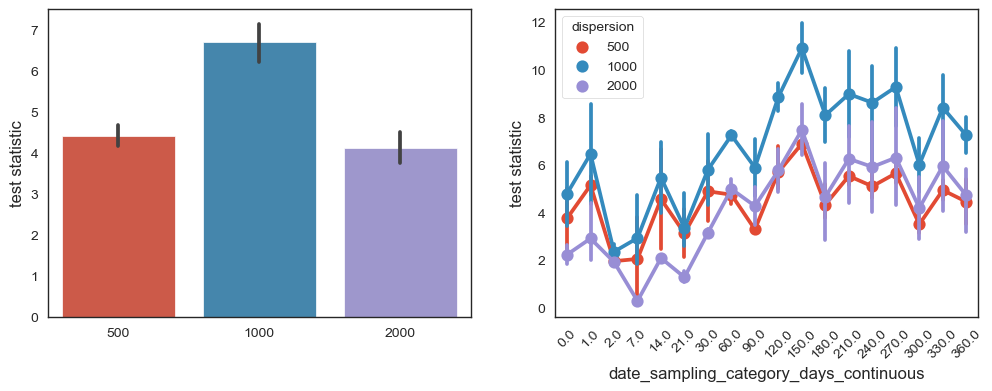

In [23]:
fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

sns.barplot(x='dispersion', y='test statistic', data=permanova_results_df, 
            ci=68, ax=axn[0])
axn[0].set_facecolor('white')
axn[0].set_xlabel('')
sns.pointplot(x=state_column, hue='dispersion', y='test statistic', 
              data=permanova_results_df, ci=68, ax=axn[1])
axn[1].set_facecolor('white')
plt.xticks(rotation=45)
plt.show()

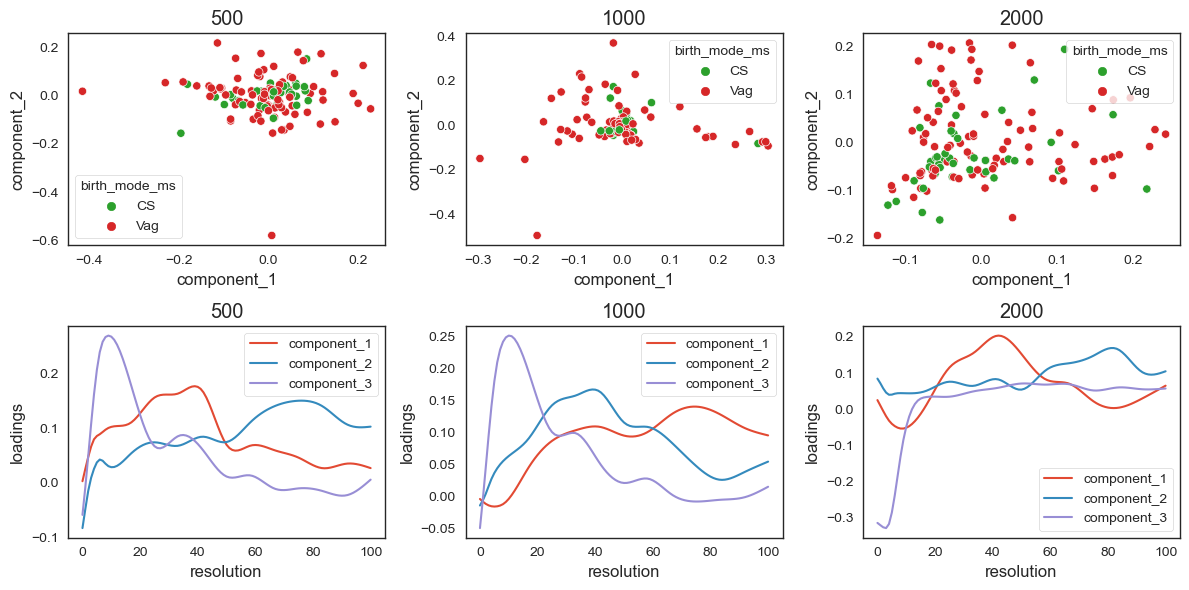

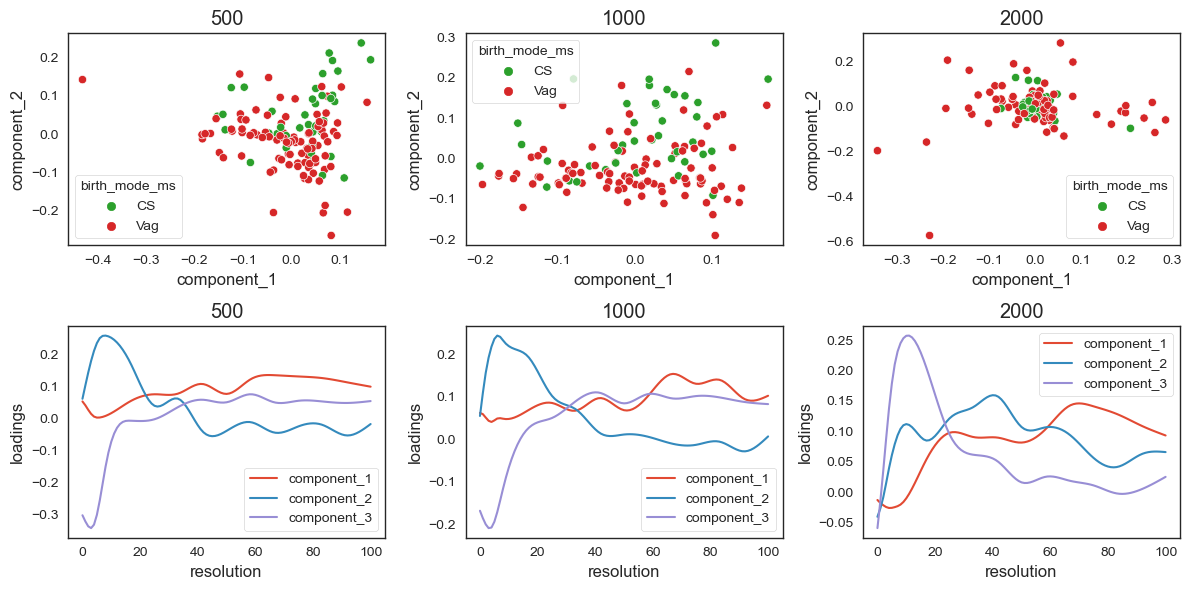

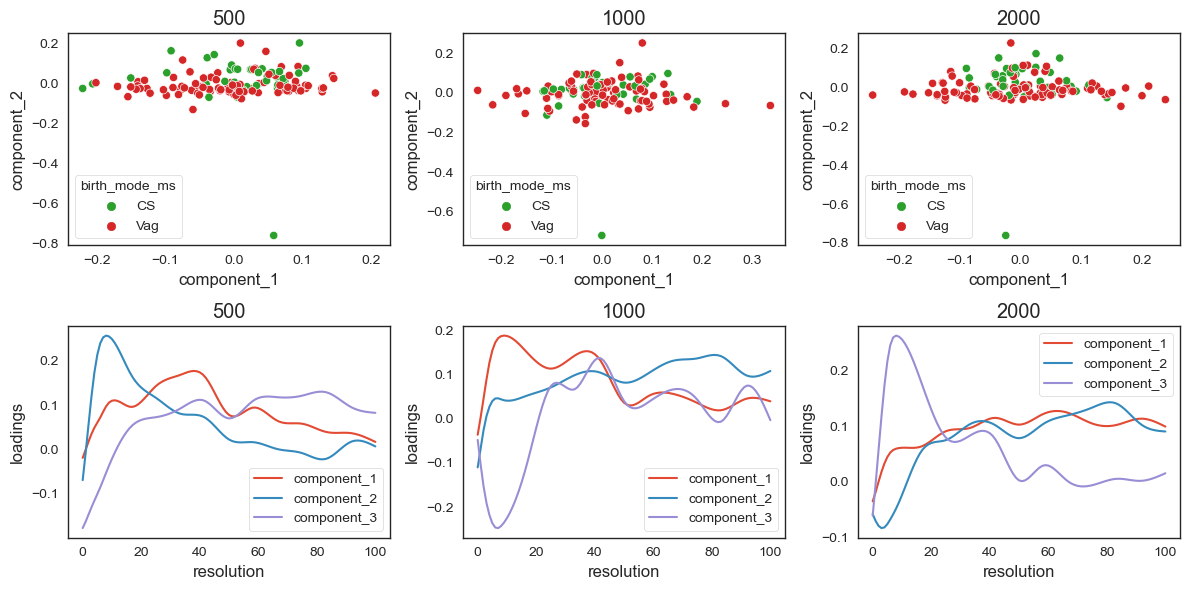

In [26]:
sns.set_style('white')

for fold_ in range(3):

    depth_ = 10000
    cols = sorted(set([int(k[1]) for k in simulation_results.keys()]))
    fig, axn = plt.subplots(2, len(cols), figsize=(12, 6))
    mf_subject_collapsed = mf.groupby(subject_id_column).agg({cat_of_interest:'first'})
    group_colors = {'Vag': 'tab:red', 'CSseed': 'tab:blue', 'CS': 'tab:green'}
    comp1 = 'component_1'
    comp2 = 'component_2'

    for i, disp_ in enumerate(cols):
        ind_loads, _, state_loads, _, _, _ = simulation_results[(depth_, disp_, fold_)]
        sns.scatterplot(x=ind_loads['16S'][comp1], 
                        y=ind_loads['16S'][comp2],  
                        hue=mf_subject_collapsed[cat_of_interest], 
                        palette=group_colors, ax=axn[0,i])
        axn[0,i].set_title(disp_)

        sns.lineplot(data=state_loads['16S'][['component_1', 'component_2', 'component_3']], 
                     ax=axn[1,i], dashes=False)
        axn[1,i].set_title(disp_)
        axn[1,i].legend() 
        axn[1,i].set_xlabel('resolution')         
        axn[1,i].set_ylabel('loadings') 

    plt.tight_layout()
    plt.show()